# Distributed FWI with Devito using Tensorflow and Dask

## Inversion Computational Setup

### Setting up (synthetic) data

In [1]:
import cloudpickle as pickle
from examples.seismic import TimeAxis, RickerSource, Receiver
from examples.seismic.acoustic import AcousticWaveSolver

saved_true_model_file = "true_model.npy"
saved_smooth_model_file = "smooth_model.npy"
saved_shot_data_file_prefix = "shot"


def dump_model(model, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(model, f)


def get_model(file_name):
    with open(file_name, "rb") as f:
        return pickle.load(f)
        

def dump_shot_data(shot_id, src, true_data):
    with open('{}_{}'.format(saved_shot_data_file_prefix, shot_id), 'wb') as f:
        pickle.dump({'src': src, 'rec': true_data}, f)


def load_shot_data(shot_id, dt):
    shot_data = pickle.load(open('{}_{}'.format(saved_shot_data_file_prefix, shot_id), 'rb'))
    shot_data['src'] = shot_data['src'].resample(dt)
    shot_data['rec'] = shot_data['rec'].resample(dt)
    return shot_data


def generate_shot_data(t0, tn, f0, shots, receivers, client):
    params = [t0, tn, f0, shots, receivers]
    work = [params + [shot_id] for shot_id in range(shots)]

    fgi = [client.submit(generate_shot_data_i, *job) for job in work]

    wait(fgi)


def generate_shot_data_i(t0, tn, f0, shots, receivers, shot_id):
    true_model = get_model(saved_true_model_file)

    # Time step from model grid spacing
    dt = true_model.critical_dt

    # Acquisitional Geometry
    time_range = TimeAxis(start=t0, stop=tn, step=dt)
    src = RickerSource(name="src", grid=true_model.grid, f0=f0,
                       time_range=time_range)
    
    src.coordinates.data[0, :] = [30, shot_id*1000./(shots-1)]
    
    rec = Receiver(name="rec", grid=true_model.grid, time_range=time_range,
                   npoint=receivers)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0],
                                             num=receivers)
    rec.coordinates.data[:, 0] = 980.  # 20m from the right end

    # set up solver
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # generate synthetic receiver data from true model
    true_data, _, _ = solver.forward(src=src, m=true_model.m)

    dump_shot_data(shot_id, src, true_data)

### Computational Consideration

In [2]:
shape = (101, 101)
spacing = (10., 10.)
origin = (0., 0.)

shots = 9
receivers = 101
epochs = 5

# dask workers
workers = 2

t0 = 0.
tn = 1000.
f0 = 0.01

### True and Smooth Models

In [3]:
from examples.seismic import demo_model, plot_velocity, plot_perturbation
from devito import configuration
from distributed import Client, LocalCluster, wait

configuration['log_level'] = 'WARNING'

true_model = demo_model('circle-isotropic', vp=3.0, vp_background=2.5,
                        origin=origin, shape=shape, spacing=spacing, nbpml=40)

smooth_model = demo_model('circle-isotropic', vp=2.5, vp_background=2.5,
                          origin=origin, shape=shape, spacing=spacing, nbpml=40)

## Dask Specifics

In [4]:
class fg_pair:
    def __init__(self, f, g):
        self.f = f
        self.g = g

    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        return fg_pair(f, g)

    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

## Operators for gradient based inversion

In [5]:
from devito import Function

def fwi_gradient_i(shot_id):
    from devito import clear_cache
    
    clear_cache()

    smooth_model = get_model(saved_smooth_model_file)

    params = load_shot_data(shot_id, smooth_model.critical_dt)
    src = params['src']
    rec = params['rec']
    
    solver = AcousticWaveSolver(smooth_model, src, rec, space_order=4)

    smooth_data, u0, _ = solver.forward(src=src, m=smooth_model.m, save=True)

    residual = Receiver(name='rec', grid=smooth_model.grid,
                        time_range=rec.time_range,
                        coordinates=rec.coordinates.data)

    residual.data[:] = smooth_data.data[:] - rec.data[:]

    f = .5*np.linalg.norm(residual.data.flatten())**2

    grad = Function(name="grad", grid=smooth_model.grid)
    solver.gradient(rec=residual, u=u0, m=smooth_model.m, grad=grad)

    g = np.array(grad.data[:])

    return fg_pair(f, g)

In [6]:
def fwi_gradient(client, smooth_model, shots):
    dump_model(smooth_model, saved_smooth_model_file)

    # Distribute job to workers - equivalent to the use of client.map(..)
    fgi = [client.submit(fwi_gradient_i, shot_id) for shot_id in range(shots)]

    # Distribute worklist to workers
    total = client.submit(sum, fgi)
    fg = total.result()

    return fg.f, fg.g

## FWI with Tensorflow

In [7]:
import tensorflow as tf
import numpy as np
import functools as ft
from dask.distributed import Client, LocalCluster, wait
from dask_kubernetes import KubeCluster, make_pod_spec

class TF_Devito_Fwi:

    def __init__(self, nshots, nreceivers, true_model, smooth_model,
                 t0, tn, f0, optimizer_func, hparams, workers=2):
        # True and Smooth velocity models
        dump_model(true_model, saved_true_model_file)
        self.smooth_model = smooth_model
        true_data = true_model.m.data
        
        # Cluster setup
        cluster = LocalCluster(n_workers=workers, death_timeout=600)
        # cluster = KubeCluster.from_yaml('./pod_config.yaml')
        # cluster.adapt()
        client = Client(cluster)
        fwi_gradient_call = ft.partial(fwi_gradient, client, smooth_model, nshots)

        generate_shot_data(t0, tn, f0, nshots, nreceivers, client)

        # Create the tf graph
        self.smooth_data = tf.Variable(self.smooth_model.m.data)
        f, g = tf.py_func(fwi_gradient_call, [], [tf.float64, tf.float32])
        if 'learning_rate' in list(hparams.keys()):
            alpha = hparams['learning_rate']
        else: 
            alpha = 0.005 / tf.reduce_max(g)
        optimizer = optimizer_func(alpha, **hparams)
        
        self.train_op = optimizer.apply_gradients([(g, self.smooth_data)])
        
        self.relative_error = tf.norm((self.smooth_data-true_data)/true_data)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())    
        
    def train(self, epochs):
        for i in range(0, epochs):
            _, re = self.sess.run([self.train_op, self.relative_error])
            yield re
        self.smooth_model.m.data[:] = self.smooth_data.eval(session=self.sess)

### Initialise FWI process

In [8]:
optimizer = tf.train.MomentumOptimizer

hparam = {'momentum': 0.4, 'use_nesterov': True}

fwi = TF_Devito_Fwi(shots, receivers, true_model, smooth_model,
                    t0, tn, f0, optimizer, hparam, workers)

relative_losses = np.zeros((epochs, 1))

for i, rl in enumerate(fwi.train(epochs)):
    print("Epoch: {}, Relative Losses: {}".format(i, rl))
    relative_losses[i] = rl

/Users/rajatrasal/anaconda3/envs/TF_Devito_FWI/lib/python3.6/site-packages/distributed/bokeh/core.py:55: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Epoch: 0, Relative Losses: 11.773591041564941
Epoch: 1, Relative Losses: 11.773747444152832
Epoch: 2, Relative Losses: 11.7743501663208
Epoch: 3, Relative Losses: 11.775471687316895
Epoch: 4, Relative Losses: 11.77712631225586


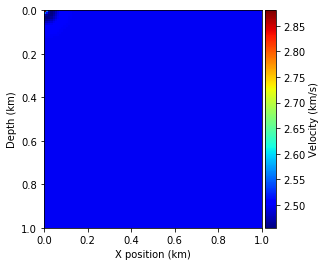

In [9]:
nbpml = true_model.nbpml
smooth_model.vp = np.sqrt(1. / smooth_model.m.data[nbpml:-nbpml, nbpml:-nbpml])

plot_velocity(smooth_model)

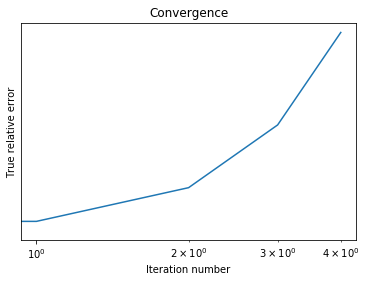

In [10]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(relative_losses)
plt.xlabel('Iteration number')
plt.ylabel('True relative error')
plt.title('Convergence')
plt.show()